# LangGraph-style Case Triage Demo

Minimal, top-to-bottom demo of a LangGraph-style case triage pipeline.

Cells:
1. Environment & imports
2. Shim and data models
3. Agents (core + extras)
4. Graph wiring and run helper
5. Visualization (inline)
6. Smoke test

No external services or credentials required. Graphviz is needed for PNG rendering.

In [50]:
# Environment & imports
from __future__ import annotations
import os
import sys
import random
import logging
import shutil
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Callable

RANDOM_SEED = 42
logger = logging.getLogger("langgraph_demo")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("%(asctime)s %(levelname)s %(message)s"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

def deterministic_seed():
    random.seed(RANDOM_SEED)


In [51]:
# Lightweight LangGraph shim + data models
from dataclasses import dataclass
from typing import Callable, Dict, List, Any

@dataclass
class Edge:
    src: str
    dst: str
    metadata: Dict[str, Any] = None

class Graph:
    def __init__(self):
        self.nodes: Dict[str, Callable[[Any], Any]] = {}
        self.edges: List[Edge] = []

    def add_node(self, name: str, handler: Callable[[Any], Any]):
        self.nodes[name] = handler

    def add_edge(self, src: str, dst: str, metadata: Dict[str, Any] = None):
        self.edges.append(Edge(src, dst, metadata))

    def run(self, start: str, payload: Any) -> Dict[str, Any]:
        deterministic_seed()
        results: Dict[str, Any] = {}
        queue = [(start, payload)]
        visited = set()
        while queue:
            node, data = queue.pop(0)
            if node in visited:
                continue
            visited.add(node)
            handler = self.nodes.get(node)
            if not handler:
                logger.warning("No handler for node %s", node)
                continue
            try:
                res = handler(data)
                results[node] = res
            except Exception as e:
                logger.exception("Handler %s failed: %s", node, e)
                results[node] = None
            children = sorted([e.dst for e in self.edges if e.src == node])
            for c in children:
                queue.append((c, results[node]))
        return results

@dataclass
class Ticket:
    id: str
    title: str
    description: str
    status: str = "New"
    owner: Optional[str] = None
    comments: List[str] = None

    def __post_init__(self):
        if self.comments is None:
            self.comments = []

@dataclass
class TriageResult:
    priority: str
    reason: str
    score: float


In [52]:
# Agents: core + enrichment/prioritization/escalation/notification
from typing import List, Dict

class TriageAgent:
    def __init__(self, rules: Optional[Dict[str,str]] = None):
        self.rules = rules or {"urgent":"High", "error":"High", "slow":"Medium", "feature":"Low"}

    def handle(self, ticket: Ticket) -> TriageResult:
        text = f"{ticket.title} {ticket.description}".lower()
        for k, v in self.rules.items():
            if k in text:
                score = 0.9 if v == "High" else 0.6 if v == "Medium" else 0.2
                logger.info("Triage: matched %s -> %s", k, v)
                return TriageResult(priority=v, reason=f"matched:{k}", score=score)
        return TriageResult(priority="Low", reason="no-match", score=0.1)

class KBSearchAgent:
    def __init__(self, docs: Optional[List[Dict[str,str]]] = None):
        self.docs = docs or []

    def search(self, triage: TriageResult) -> List[Dict[str,Any]]:
        k = triage.reason.replace("matched:", "")
        results = [{"id":d.get("id"), "score": (1.0 if k in d.get("text","") else 0.0)} for d in self.docs]
        results.sort(key=lambda x: (-x["score"], x["id"]))
        logger.info("KBSearch: found %d candidates", len(results))
        return results

class SalesforceAgent:
    def __init__(self):
        self.store: Dict[str, Ticket] = {}

    def fetch(self, ticket_id: str) -> Optional[Ticket]:
        return self.store.get(ticket_id)

    def upsert(self, ticket: Ticket):
        self.store[ticket.id] = ticket
        return ticket

class TicketActionAgent:
    def apply(self, triage: TriageResult, ticket: Ticket) -> Ticket:
        if triage.priority == "High":
            ticket.status = "In Progress"
        ticket.comments.append(f"Auto-triaged: {triage.priority} ({triage.reason})")
        logger.info("TicketAction: updated %s -> status=%s", ticket.id, ticket.status)
        return ticket

class EnrichmentAgent:
    def enrich(self, triage: TriageResult, kb_results: List[Dict[str,Any]]) -> TriageResult:
        tags = [r["id"] for r in kb_results if r.get("score", 0) > 0]
        if tags:
            triage.reason = f"{triage.reason}|enriched:{','.join(tags)}"
            triage.score = min(1.0, triage.score + 0.05 * len(tags))
            logger.info("Enrichment: added tags %s", tags)
        return triage

class PrioritizationAgent:
    def reprioritize(self, triage: TriageResult, kb_results: List[Dict[str,Any]]) -> TriageResult:
        top = any(r.get("score") == 1.0 for r in kb_results)
        if top and triage.priority != "High":
            triage.priority = "High"
            triage.score = max(triage.score, 0.9)
            logger.info("Prioritization: bumped to High")
        return triage

class EscalationAgent:
    def evaluate(self, triage: TriageResult, ticket: Ticket) -> Ticket:
        if triage.priority == "High" and triage.score >= 0.8:
            ticket.owner = "L2 Team"
            ticket.comments.append(f"Escalated: assigned to {ticket.owner}")
            logger.info("Escalation: ticket %s escalated to %s", ticket.id, ticket.owner)
        return ticket

class NotificationAgent:
    def __init__(self):
        self.notifications: List[Dict[str,Any]] = []

    def notify(self, ticket: Ticket, triage: TriageResult) -> Dict[str,Any]:
        note = {"ticket_id": ticket.id, "priority": triage.priority, "msg": f"Notify: {ticket.id} => {triage.priority}"}
        self.notifications.append(note)
        logger.info("Notification: recorded %s", note)
        return note


In [53]:
# Graph wiring and run helper
triage_agent = TriageAgent()
kb_agent = KBSearchAgent(docs=[{"id":"kb1","text":"urgent error in login"},{"id":"kb2","text":"feature request for UI"}])
sf_agent = SalesforceAgent()
action_agent = TicketActionAgent()
enrich_agent = EnrichmentAgent()
prio_agent = PrioritizationAgent()
escalation_agent = EscalationAgent()
notify_agent = NotificationAgent()

node_types = {
    "triage": "ingest",
    "kb_search": "search",
    "enrich": "enrichment",
    "prioritize": "prioritization",
    "sf_fetch": "storage",
    "escalate": "escalation",
    "ticket_action": "action",
    "notify": "notification",
}

# handlers
def triage_handler(ticket: Ticket) -> TriageResult:
    return triage_agent.handle(ticket)

def kb_handler(payload: Any):
    if isinstance(payload, tuple):
        payload = payload[0]
    if isinstance(payload, TriageResult):
        return kb_agent.search(payload)
    return []

def enrich_handler(payload: Any):
    if isinstance(payload, tuple):
        tri = payload[0]
        kb = payload[1] if len(payload) > 1 else []
        return enrich_agent.enrich(tri, kb)
    if isinstance(payload, TriageResult):
        return enrich_agent.enrich(payload, [])
    return payload

def prioritize_handler(payload: Any):
    if isinstance(payload, tuple):
        tri = payload[0]
        kb = payload[1] if len(payload) > 1 else []
        return prio_agent.reprioritize(tri, kb)
    if isinstance(payload, TriageResult):
        return prio_agent.reprioritize(payload, [])
    return payload

def sf_fetch_handler(payload: Any):
    if isinstance(payload, Ticket):
        return sf_agent.fetch(payload.id)
    if isinstance(payload, TriageResult):
        if len(sf_agent.store) == 1:
            return next(iter(sf_agent.store.values()))
        for t in sf_agent.store.values():
            if payload.reason.replace("matched:", "") in (t.title + t.description).lower():
                return t
        return None
    return None

def escalate_handler(payload: Any):
    if isinstance(payload, tuple) and isinstance(payload[0], TriageResult) and isinstance(payload[1], Ticket):
        tri, ticket = payload[0], payload[1]
        return escalation_agent.evaluate(tri, ticket)
    return payload

def action_handler(payload: Any):
    if isinstance(payload, tuple) and len(payload) == 2 and isinstance(payload[0], TriageResult):
        triage_res, ticket = payload
        return action_agent.apply(triage_res, ticket)
    elif isinstance(payload, Ticket):
        return payload
    return None

def notify_handler(payload: Any):
    if isinstance(payload, tuple) and isinstance(payload[0], Ticket) and isinstance(payload[1], TriageResult):
        ticket, tri = payload[0], payload[1]
        return notify_agent.notify(ticket, tri)
    return None

# graph
g = Graph()
for name, handler in [
    ("triage", triage_handler),
    ("kb_search", kb_handler),
    ("enrich", enrich_handler),
    ("prioritize", prioritize_handler),
    ("sf_fetch", sf_fetch_handler),
    ("escalate", escalate_handler),
    ("ticket_action", action_handler),
    ("notify", notify_handler),
]:
    g.add_node(name, handler)

g.add_edge("triage", "kb_search")
g.add_edge("kb_search", "enrich")
g.add_edge("enrich", "prioritize")
g.add_edge("prioritize", "sf_fetch")
g.add_edge("sf_fetch", "escalate")
g.add_edge("escalate", "ticket_action")
g.add_edge("ticket_action", "notify")

# run helper
def run_case(ticket: Ticket):
    deterministic_seed()
    sf_agent.upsert(ticket)
    results = g.run("triage", ticket)
    tri = results.get("triage")
    kb = results.get("kb_search") or []
    tri = enrich_agent.enrich(tri, kb)
    tri = prio_agent.reprioritize(tri, kb)
    fetched = sf_agent.fetch(ticket.id)
    if tri and fetched:
        escalation_agent.evaluate(tri, fetched)
        action_agent.apply(tri, fetched)
        notify_agent.notify(fetched, tri)
    return {"triage": tri, "kb": kb, "ticket": fetched, "notifications": notify_agent.notifications}

# sample
sample = Ticket(id="CASE-123", title="Urgent: login error", description="Users cannot login")


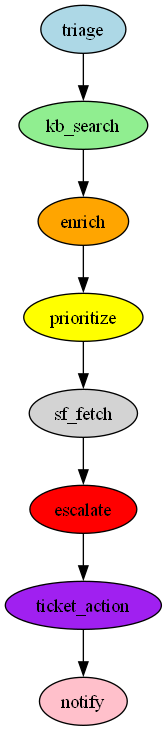

'c:\\Documents\\agent_graph.png'

In [54]:
# Visualization: inline colored graph
from IPython.display import Image, display

def render_graph_to_png(graph: Graph, out_path: Optional[str] = None, node_types_map: Optional[Dict[str,str]] = None) -> Optional[str]:
    try:
        import networkx as nx
        import pydot
    except Exception:
        logger.info("pydot/networkx not available; falling back to textual graph")
        children = {n: [e.dst for e in graph.edges if e.src == n] for n in graph.nodes}
        print("Graph adjacency:")
        for k, v in children.items():
            print(f"  {k} -> {v}")
        return None

    nxg = nx.DiGraph()
    for n in graph.nodes:
        nxg.add_node(n)
    for e in graph.edges:
        nxg.add_edge(e.src, e.dst)

    types = node_types_map or {}
    palette = {
        "ingest": "lightblue",
        "search": "lightgreen",
        "enrichment": "orange",
        "prioritization": "yellow",
        "storage": "lightgrey",
        "escalation": "red",
        "action": "purple",
        "notification": "pink",
    }

    dot = nx.nx_pydot.to_pydot(nxg)
    for n in dot.get_nodes():
        name = n.get_name().strip('"')
        color = palette.get(types.get(name, ""), "white")
        n.set_fillcolor(color)
        n.set_style('filled')

    dot_bin = shutil.which("dot")
    if not dot_bin:
        candidates = [
            r"C:\\Program Files\\Graphviz\\bin\\dot.exe",
            r"C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe",
        ]
        for c in candidates:
            if os.path.exists(c):
                dot_bin = c
                break
    if not dot_bin:
        logger.warning("dot not found; textual fallback")
        print(dot.to_string())
        return None

    out_path = out_path or os.path.join(os.getcwd(), "agent_graph.png")
    try:
        dot.write_png(out_path)
        display(Image(filename=out_path))
        return out_path
    except Exception as e:
        logger.exception("Failed to write PNG: %s", e)
        return None

# render inline
png_path = render_graph_to_png(g, node_types_map=node_types)
png_path


In [55]:
# Smoke test: run and assert key outcomes
snapshot = run_case(sample)
tri = snapshot["triage"]
assert isinstance(tri, TriageResult)
updated = snapshot["ticket"]
assert updated is not None
assert any("Auto-triaged" in c for c in updated.comments), "Auto-triage comment missing"
assert any(n["ticket_id"] == updated.id for n in snapshot["notifications"]), "Notification should have been recorded"
print("Smoke test PASS:", updated.id, updated.status, updated.comments[-1])
png_path


2025-09-06 12:07:27,699 INFO Triage: matched urgent -> High
INFO:langgraph_demo:Triage: matched urgent -> High
2025-09-06 12:07:27,700 INFO KBSearch: found 2 candidates
INFO:langgraph_demo:KBSearch: found 2 candidates
2025-09-06 12:07:27,702 INFO Enrichment: added tags ['kb1']
INFO:langgraph_demo:Enrichment: added tags ['kb1']
2025-09-06 12:07:27,703 INFO Escalation: ticket CASE-123 escalated to L2 Team
INFO:langgraph_demo:Escalation: ticket CASE-123 escalated to L2 Team
2025-09-06 12:07:27,704 INFO TicketAction: updated CASE-123 -> status=In Progress
INFO:langgraph_demo:TicketAction: updated CASE-123 -> status=In Progress
2025-09-06 12:07:27,704 INFO Notification: recorded {'ticket_id': 'CASE-123', 'priority': 'High', 'msg': 'Notify: CASE-123 => High'}
INFO:langgraph_demo:Notification: recorded {'ticket_id': 'CASE-123', 'priority': 'High', 'msg': 'Notify: CASE-123 => High'}


Smoke test PASS: CASE-123 In Progress Auto-triaged: High (matched:urgent|enriched:kb1)


'c:\\Documents\\agent_graph.png'

In [ ]:
# Notes & reproducibility
# - To reproduce rendering: pip install networkx pydot
# - System Graphviz (dot) must be installed and available in PATH for PNG output
# - Restart kernel and run cells top-to-bottom for a clean run
print("Notebook minimized. Run cells from top to bottom to re-create state.")


Smoke test passed: status= In Progress comments= ['Auto-triaged: urgent']
